In [ ]:
!mamba install pytorch=1.12 torchvision torchaudio cudatoolkit=11.3 -c pytorch -y -q

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-geometric

In [ ]:
!mamba install -c conda-forge pyts -q -y

In [ ]:
!pip install llvmpy
!pip install cython
!pip install numba
!pip install pandas
!pip install networkx
!pip install matplotlib
!pip install ts2vg
!pip install pytorch_lightning
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
import sklearn
import os.path as osp
import matplotlib.pyplot as plt
import ts2vg
import pytorch_lightning as pl
import tensorflow as tf
import datetime

from pyts.image import MarkovTransitionField

from torch.nn import Linear, CrossEntropyLoss
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool, ChebConv, global_sort_pool
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, GINEConv, GATv2Conv, GATConv

from tqdm import tqdm

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE

from torchvision import transforms

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateFinder
from pytorch_lightning.callbacks import BatchSizeFinder
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

from ts2vg import NaturalVG
from ts2vg import HorizontalVG

In [3]:
#function for graph creation
def create_MTF_graph():
    warnings.filterwarnings("ignore")
    # preparation for un/cut graphs
    if len_type == "un/cut":
    
        df = pd.read_csv(path_main)  
        del df['Unnamed: 0']
        df.index, df.columns = [range(df.index.size), range(df.columns.size)]
        length_rss = int((df.columns.stop-2)/2)
        
        X = df.loc[:,df.columns[:length_rss]].to_numpy()
        Y = df[length_rss+1].to_numpy(dtype=np.uint8)
        X_mask = df.loc[:,df.columns[length_rss+2:]].to_numpy()
        
        MTF = MarkovTransitionField(n_bins=length_rss)
        X_gaf = MTF.fit_transform(X)
        
    # preparation for random graphs
    elif len_type == "random":
        dataset_rss = np.load(path_main, allow_pickle=True)['arr_0']
        dataset_properties = np.load(path_properties, allow_pickle=True)['arr_0']
        dataset_mask = np.load(path_mask, allow_pickle=True)['arr_0']

        for i in range(len(dataset_properties)):
            if  dataset_properties[i,1] == True:
                dataset_properties[i,1] = 1
            else:
                dataset_properties[i,1] = 0
        
        X = dataset_rss
        X_mask = dataset_mask
        Y = dataset_properties[:,2]
        Y_len = dataset_properties[:,0]

        X_gaf = []
        for i in range(len(Y_len)):
            
            MTF = MarkovTransitionField(n_bins=Y_len[i])
            X_gaf_temp = MTF.fit_transform(X[i].reshape(1, -1))
            X_gaf.append(X_gaf_temp[0])
    
    # output will have all graphs 
    output = []
    
    # setting class_weights for graph
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
    # function for creating edge index and edge weight for a given MTF matrix
    def adjToEdgidx(adj_mat):
        edge_index = torch.from_numpy(adj_mat).nonzero().t().contiguous()
        row, col = edge_index
        edge_weight = adj_mat[row, col]#adj_mat[row, col]
        return edge_index, edge_weight
    
    for i, j in enumerate(X_gaf):
        edge_index, edge_weight = adjToEdgidx(j)
        #Into Data save node values "x", edge index from adjacency matrix and edge features/attributes, finally labels
        
        if classif == "graph": # for graph classification
            y_mask = torch.tensor(Y[i], dtype=torch.long)      
        elif classif == "node":                 # for node classification 
            y_mask = torch.unsqueeze(torch.tensor(X_mask[i], dtype=torch.double),1)
            
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), edge_index=edge_index, edge_attr=torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1), y=y_mask))
    
    return output

In [4]:
 #function for graph creation
def create_visual_graph():
    # warnings.filterwarnings("ignore")
    # preparation for un/cut graphs
    if len_type == "un/cut":
    
        df = pd.read_csv(path_main)  
        del df['Unnamed: 0']
        df.index, df.columns = [range(df.index.size), range(df.columns.size)]
        length_rss = int((df.columns.stop-2)/2)
        
        X = df.loc[:,df.columns[:length_rss]].to_numpy()
        Y = df[length_rss+1].to_numpy(dtype=np.uint8)
        X_mask = df.loc[:,df.columns[length_rss+2:]].to_numpy()
        
        
    # preparation for random graphs
    elif len_type == "random":
        
        dataset_rss = np.load(path_main, allow_pickle=True)['arr_0']
        dataset_properties = np.load(path_properties, allow_pickle=True)['arr_0']
        dataset_mask = np.load(path_mask, allow_pickle=True)['arr_0']

        for i in range(len(dataset_properties)):
            if  dataset_properties[i,1] == True:
                dataset_properties[i,1] = 1
            else:
                dataset_properties[i,1] = 0
        
        X = dataset_rss
        X_mask = dataset_mask
        Y = dataset_properties[:,2]
        Y_len = dataset_properties[:,0]

    # output will have all graphs 
    output = []
    
    # setting class_weights for graph
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
    # function for creating edge index and edge weight for a given MTF matrix
    def adjToEdgidx(X_current):
        g = NaturalVG(weighted='distance')
        # g = HorizontalVG(weighted='distance')
        g.build(X_current)

        adj_mat_visual = np.zeros([len(X_current),len(X_current)], dtype='float')
        for i in range(len(g.edges)):
            x, y, q =g.edges[i]
            adj_mat_visual[x,y] = q#/g.weights.max()
            adj_mat_visual[y,x] = q#/g.weights.max()
        
        edge_index = torch.from_numpy(adj_mat_visual).nonzero().t().contiguous()
        row, col = edge_index
        edge_weight = adj_mat_visual[row, col]
        
        return edge_index, edge_weight
    
    for i in range(len(X)):
        edge_index, edge_weight = adjToEdgidx(X[i])
        
        if classif == "graph": # for graph classification
            y_mask = torch.tensor(Y[i], dtype=torch.long)      
        elif classif == "node":                 # for node classification 
            y_mask = torch.unsqueeze(torch.tensor(X_mask[i], dtype=torch.double),1)
        
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), 
                           edge_index=torch.tensor(edge_index, dtype=torch.int64), 
                           edge_attr=torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1),
                           y=y_mask))
    return output


In [5]:
def create_join_graph():
    
    warnings.filterwarnings("ignore")
    # preparation for un/cut graphs
    if len_type == "un/cut":
    
        df = pd.read_csv(path_main)  
        del df['Unnamed: 0']
        df.index, df.columns = [range(df.index.size), range(df.columns.size)]
        length_rss = int((df.columns.stop-2)/2)
        
        X = df.loc[:,df.columns[:length_rss]].to_numpy()
        Y = df[length_rss+1].to_numpy(dtype=np.uint8)
        X_mask = df.loc[:,df.columns[length_rss+2:]].to_numpy()
        
        MTF = MarkovTransitionField(n_bins=length_rss)
        X_gaf = MTF.fit_transform(X)
        
    # preparation for random graphs
    elif len_type == "random":
        dataset_rss = np.load(path_main, allow_pickle=True)['arr_0']
        dataset_properties = np.load(path_properties, allow_pickle=True)['arr_0']
        dataset_mask = np.load(path_mask, allow_pickle=True)['arr_0']

        for i in range(len(dataset_properties)):
            if  dataset_properties[i,1] == True:
                dataset_properties[i,1] = 1
            else:
                dataset_properties[i,1] = 0
        
        X = dataset_rss
        X_mask = dataset_mask
        Y = dataset_properties[:,2]
        Y_len = dataset_properties[:,0]

        X_gaf = []
        for i in range(len(Y_len)):
            
            MTF = MarkovTransitionField(n_bins=Y_len[i])
            X_gaf_temp = MTF.fit_transform(X[i].reshape(1, -1))
            X_gaf.append(X_gaf_temp[0])
    
    # output will have all graphs 
    output = []
    
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
        
    def adjToEdgidx(adj_mat_MTF,X_current):
        g = NaturalVG(weighted='distance')
        #g = HorizontalVG(weighted='distance')
        g.build(X_current)
        
        #create matrix for visual
        adj_mat_visual = np.zeros([len(adj_mat_MTF),len(adj_mat_MTF)], dtype='float')
        for i in range(len(g.edges)):
            x, y, q =g.edges[i]
            adj_mat_visual[x,y] = q#/g.weights.max()
            adj_mat_visual[y,x] = q#/g.weights.max()
        
        edge_index = torch.from_numpy(adj_mat_MTF).nonzero().t().contiguous()
        
        #join two edge_weight arrays (visual is converted to fit MTF) 
        row, col = edge_index
        edge_weight = np.zeros([len(row),2], dtype='float')
        edge_weight[:,0] = adj_mat_MTF[row, col]
        edge_weight[:,1] = adj_mat_visual[row, col]
        
        # edge_weight = np.reshape(edge_weight,(len(edge_weight),2))
        
        return edge_index, edge_weight
    
    for i, j in enumerate(X_gaf):
        edge_index, edge_weight = adjToEdgidx(j,X[i])
        
        if classif == "graph": # for graph classification
            y_mask = torch.tensor(Y[i], dtype=torch.long)      
        elif classif == "node":                 # for node classification 
            y_mask = torch.unsqueeze(torch.tensor(X_mask[i], dtype=torch.double),1)
            
        #Into Data save node values "x", edge index from adjacency matrix and edge features/attributes, finally labels       
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), 
                    edge_index=edge_index, 
                    edge_attr=torch.tensor(edge_weight, dtype=torch.double), 
                    y=y_mask))
    return output

In [6]:
## Focal loss definition

In [7]:
class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma=1, alpha=None, ignore_index=-100, reduction='mean'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        
        
        if self.reduction == 'mean':
            return torch.mean(loss) 
        elif self.reduction == 'sum':
            return torch.sum(loss) 
        else:
            return loss

In [8]:
#keeps the last output so we dont have to generate another if all parameters are the same as before
global temp_repeat
temp_repeat=['']*6
def generate_output():
    if temp_repeat[0] != graph_type or temp_repeat[1] != classif or temp_repeat[2] != len_type or temp_repeat[3] != path_main or temp_repeat[4] != path_properties or temp_repeat[5] != path_mask:
    
        global output
        if graph_type == "MTF":
            output = create_MTF_graph()
        if graph_type == "visual":
            output = create_visual_graph()
    
    temp_repeat[0] = graph_type 
    temp_repeat[1] = classif
    temp_repeat[2] = len_type
    temp_repeat[3] = path_main
    temp_repeat[4] = path_properties
    temp_repeat[5] = path_mask
    
    return output

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=98` reached.
LR finder stopped early after 98 steps due to diverging loss.
Restoring states from the checkpoint path at /home/jovyan/Git /GNN_for_LQE_dataset/.lr_find_78e46b75-2ab2-49df-b732-6a692c1c6d56.ckpt
Restored all states from the checkpoint file at /home/jovyan/Git /GNN_for_LQE_dataset/.lr_find_78e46b75-2ab2-49df-b732-6a692c1c6d56.ckpt


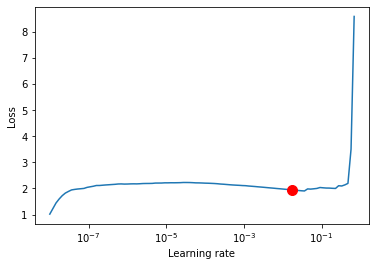

In [18]:
#definitions of all Callbacks
early_stop = EarlyStopping(monitor='val_acc',patience=300, strict=False,verbose=False, mode='max')
model_chackpoint = ModelCheckpoint(monitor='val_loss', mode='min')
val_checkpoint_acc = ModelCheckpoint(filename="max_acc-{epoch}-{step}-{val_loss:.1f}", monitor = "val_acc", mode="max")
val_checkpoint_best = ModelCheckpoint(filename="best", monitor = "val_acc", mode="max")
val_checkpoint_loss = ModelCheckpoint(filename="min_loss-{epoch}-{step}-{val_loss:.1f}", monitor = "val_loss", mode="min")
latest_checkpoint = ModelCheckpoint(filename="latest-{epoch}-{step}", monitor = "step", mode="max",every_n_train_steps = 500,save_top_k = 1)
batchsizefinder = BatchSizeFinder(mode='power', steps_per_trial=3, init_val=2, max_trials=25, batch_arg_name='batch_size')
CSV_logger = CSVLogger("logs", name="my_exp_name",flush_logs_every_n_steps=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)

lr_finder = FineTuneLearningRateFinder(milestones=(5,10))



class LitAutoEncoder(pl.LightningModule):
    #Layers
    def __init__(self):
        super(LitAutoEncoder, self).__init__()
        edge_dim = 1
        dim_h = 32
        
        
        self.conv1 = GINEConv(
            Sequential(Linear(dim_h, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv2 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv3 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv4 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv5 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.lin1 = Linear(dim_h*5, dim_h*5)
        self.lin2 = Linear(dim_h*5, 5)
        self.learning_rate = learning_rate
    
    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Node embeddings 
        h1 = self.conv1(x, edge_index, edge_attr=edge_weight)
        h2 = self.conv2(h1, edge_index, edge_attr=edge_weight)
        h3 = self.conv3(h2, edge_index, edge_attr=edge_weight)
        h4 = self.conv4(h3, edge_index, edge_attr=edge_weight)
        h5 = self.conv5(h4, edge_index, edge_attr=edge_weight)
        
        # Graph-level readout
        
        h1 = global_max_pool(h1, batch)
        h2 = global_max_pool(h2, batch)
        h3 = global_max_pool(h3, batch)
        h4 = global_max_pool(h4, batch)
        h5 = global_max_pool(h5, batch)
        

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3, h4, h5), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=5e-4)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
                     
        out = model(train_batch)
        loss_function = CrossEntropyLoss(weight=class_weights).to(device) #weight=class_weights
        
        train_loss = loss_function(out, train_batch.y)
        
        correct=out.argmax(dim=1).eq(train_batch.y).sum().item()
        logs={"train_loss": train_loss}
        total=len(train_batch.y)
        
        batch_dictionary={"loss": train_loss, "log": logs, "correct": correct, "total": total}
        
        return train_loss
    
    
    def validation_step(self, val_batch, batch_idx):
      
        out = model(val_batch)
        loss_function = CrossEntropyLoss(weight=class_weights).to(device)
        val_loss = loss_function(out, val_batch.y)
        
        pred = out.argmax(-1)
        correct=out.argmax(dim=1).eq(val_batch.y).sum().item()
        total=len(val_batch.y)
        val_label = val_batch.y
        accuracy = (pred == val_label).sum() / pred.shape[0]
        
        logs={"train_loss": val_loss}
        batch_dictionary={"loss": val_loss, "log": logs, "correct": correct, "total": total}
        self.log("val_loss", val_loss)
        self.log("val_acc", accuracy)
        
    
    def test_step(self, test_batch, batch_idx):
        # this is the test loop
        out = model(test_batch)
        # class_weights.type_as("gpu")
        loss_function = CrossEntropyLoss(weight=class_weights).to(device)
        test_loss = loss_function(out, test_batch.y)
        
        pred = out.argmax(-1)
        test_label = test_batch.y
        accuracy = (pred == test_label).sum() / pred.shape[0]
        self.log("test_true", test_label)
        self.log("test_pred", pred)
        self.log("test_acc", accuracy)
        return pred, test_label
    
    #test_epoch_end, lets us gather all outputs of test_step so we can show the classificaiton_report
    def test_epoch_end(self, outputs):
        true_array=[]
        pred_array = []
        for i in range(len(outputs)):
            true_array = np.append(true_array,outputs[i][1].cpu().numpy())
            pred_array = np.append(pred_array,outputs[i][0].cpu().numpy())            
        
        print(classification_report(true_array, pred_array))
        
#Definition of all global veriables----------------------------

graph_type = "visual"#"visual", "MTF"
classif = "graph" #"graph", "node", set the type of classification
len_type = "un/cut" #"un/cut", "random", set the shape of data used in later paths 
path_main = "dataset_uncut.csv" # "dataset_cut.csv", "dataset_rss.npz", paths used for cut/uncut/random dataset
path_properties = "dataset_properties.npz"  # path to properties used for random 
path_mask = "dataset_mask.npz" # path to mask dataset used for random

batch_size = 64*4 #set the train batch size
SEED = 301
learning_rate = 0.01
range_epoch = 1000 #set length of epoch
save_file="tb_logs"
name_of_save = "len=300_5_models"
logger = TensorBoardLogger(save_file, name=name_of_save) # where the model saves the callbacks for tensorBoard
    


analysis = True
#-------------------------------------------------------------
output = generate_output()
# my data        
    
torch.manual_seed(SEED)

train_size = int(0.8 * len(output))
Temp_size = len(output) - train_size
val_size = int(0.2*Temp_size)
test_size = Temp_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(output, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model
model = LitAutoEncoder().double()#.to(device)

# #training
val_check_interval=len(train_loader)

#lr finder
trainer = pl.Trainer(auto_lr_find=True,accelerator='gpu',devices=1)
lr_finder = trainer.tuner.lr_find(model, train_loader)
fig = lr_finder.plot(suggest = True)

#running the training and validation
trainer = pl.Trainer(logger=logger,max_epochs = 1000, callbacks=[latest_checkpoint, val_checkpoint_acc,val_checkpoint_loss,lr_finder,early_stop],accelerator='gpu',devices=1)
trainer.fit(model, train_loader, val_loader)

#chose a model from checkpoint file in designated location in logger or use the generated model defined above and comment the next line
model = LitAutoEncoder.load_from_checkpoint(save_file +"/"+name_of_save +"/version_0/checkpoints/max_acc-epoch=289-step=9792-val_loss=0.0.ckpt").double()

#run the test to get classification_report
trainer.test(model, test_loader)



In [28]:
name_of_save = "len=300_5_models"
save_file="tb_logs"
model = LitAutoEncoder.load_from_checkpoint(save_file +"/"+name_of_save +"/version_0/checkpoints/max_acc-epoch=704-step=23902-val_loss=0.0.ckpt").double()